# Plan2Plan
Author: Jason Jabbour

# Load Dependencies

In [28]:
import torch
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

# Plan2Plan Model

## Load Data

In [29]:
class PathPlanningDataset(Dataset):
    def __init__(self, csv_file, map_dir, transform=None):
        self.path_data = pd.read_csv(csv_file)
        self.map_dir = map_dir
        self.transform = transform
        self.pair_ids = self.path_data['pair_id'].unique()

    def __len__(self):
        return len(self.pair_ids)

    def __getitem__(self, idx):
        pair_id = self.pair_ids[idx]

        # Load map data
        map_path = os.path.join(self.map_dir, f'map_{pair_id}.json')
        with open(map_path, 'r') as f:
            map_data = np.array(json.load(f))

        # Convert map to PyTorch tensor
        map_tensor = torch.from_numpy(map_data).float()

        # Load path data
        rrt_path = self.path_data[(self.path_data['pair_id'] == pair_id) & (self.path_data['algo'] == 'RRT')][['x', 'y']].values
        astar_path = self.path_data[(self.path_data['pair_id'] == pair_id) & (self.path_data['algo'] == 'A*')][['x', 'y']].values

        # Convert paths to PyTorch tensors
        rrt_tensor = torch.from_numpy(rrt_path).float()
        astar_tensor = torch.from_numpy(astar_path).float()

        # Apply transforms if any
        if self.transform:
            map_tensor = self.transform(map_tensor)
            rrt_tensor = self.transform(rrt_tensor)
            astar_tensor = self.transform(astar_tensor)

        return {'map': map_tensor, 'rrt_path': rrt_tensor, 'astar_path': astar_tensor}

def collate_fn(batch):
    maps = [item['map'] for item in batch]
    rrt_paths = [item['rrt_path'] for item in batch]
    astar_paths = [item['astar_path'] for item in batch]

    # Get lengths of each path
    rrt_lengths = [len(path) for path in rrt_paths]
    astar_lengths = [len(path) for path in astar_paths]

    # Pad the sequences in the batch
    rrt_paths_padded = pad_sequence(rrt_paths, batch_first=True, padding_value=0)
    astar_paths_padded = pad_sequence(astar_paths, batch_first=True, padding_value=0)

    # Create attention masks based on lengths
    rrt_masks = torch.zeros_like(rrt_paths_padded)
    astar_masks = torch.zeros_like(astar_paths_padded)
    for i, length in enumerate(rrt_lengths):
        rrt_masks[i, :length] = 1
    for i, length in enumerate(astar_lengths):
        astar_masks[i, :length] = 1

    maps_stacked = torch.stack(maps)

    return {'map': maps_stacked, 'rrt_path': rrt_paths_padded, 'astar_path': astar_paths_padded, 'rrt_mask': rrt_masks, 'astar_mask': astar_masks}

# Now you can create a DataLoader using the custom collate function
batch_size = 4
dataset = PathPlanningDataset(csv_file='../PathPlanning/path_data/path_data.csv', map_dir='../PathPlanning/map_data')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

Test the data loader

In [31]:
# To test the dataloader, you can iterate over it
for i, data in enumerate(dataloader):
    print(f"Batch {i}")
    print(data['map'].shape, data['rrt_path'].shape, data['astar_path'].shape, data['rrt_mask'].shape, data['astar_mask'].shape)
    break

Batch 0
torch.Size([4, 100, 100]) torch.Size([4, 63, 2]) torch.Size([4, 100, 2]) torch.Size([4, 63, 2]) torch.Size([4, 100, 2])


Merge Path and Map

In [32]:
# Two versions, one to handly numpy arrays and one optimized for tensors during training

def modify_map_with_path(map_matrix, path):
    """
        Maps are (100,100) matrices that have 4 values.

        0: White-space no obstacle
        1: Obstacle
        2: Start
        3: End
        4: Path
    """
    modified_map = np.copy(map_matrix)
    for x, y in path:
        if 0 <= x < modified_map.shape[1] and 0 <= y < modified_map.shape[0]:
            current_value = modified_map[int(y), int(x)]
            # Start and end points have the value 2 and 3
            if current_value != 2 and current_value != 3:
                # Paths now have the value 4
                modified_map[int(y), int(x)] = 4  # Mark the RRT path
    return modified_map

def modify_map_with_path_tensor(maps, paths):
    """
    Modify maps with the given paths. Maps and paths are expected to be PyTorch tensors.

    Args:
    - maps (torch.Tensor): Tensor of shape [batch_size, 1, height, width]
    - paths (torch.Tensor): Tensor of paths, shape [batch_size, num_points, 2]

    Returns:
    - torch.Tensor: Modified maps
    """
    batch_size, _, height, width = maps.size()
    modified_maps = maps.clone()  # Clone to avoid modifying the original maps

    for i in range(batch_size):
        for point in paths[i]:
            x, y = int(point[0]), int(point[1])
            if 0 <= x < width and 0 <= y < height:
                # Avoid overriding start (2) and end (3) points
                if modified_maps[i, 0, y, x] not in {2, 3}:
                    modified_maps[i, 0, y, x] = 4  # Mark the path

    return modified_maps


Visualize Merged Path and Map

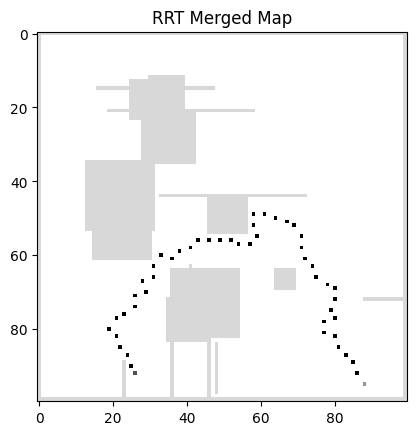

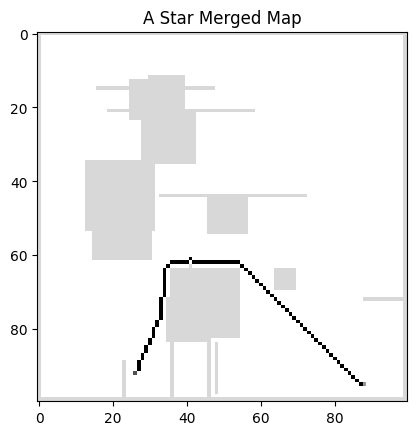

(100, 100)

In [33]:
# Get a batch of data
data = next(iter(dataloader))
maps = data['map']

# Modify the maps with the RRT paths
modified_maps = []
for i in range(maps.size(0)):
    modified_map_rrt = modify_map_with_path(maps[i].numpy(), data['rrt_path'][i].numpy())
    modified_map_astar = modify_map_with_path(maps[i].numpy(), data['astar_path'][i].numpy())
    break

# The number 4 represents the paths. 
# If you only want to display the paths then zero everything else out.
# modified_map_rrt[modified_map_rrt != 4] = 0
# modified_map_astar[modified_map_astar != 4] = 0

# Visualize the first generated map
plt.imshow(modified_map_rrt.squeeze(), cmap='Grays')
plt.title("RRT Merged Map")
plt.show()

# Visualize the first generated map
plt.imshow(modified_map_astar.squeeze(), cmap='Grays')
plt.title("A Star Merged Map")
plt.show()

modified_map_rrt.shape

## Generator

In [34]:
def downsample(in_channels, out_channels, kernel_size=3, apply_batchnorm=True):
    # Downsample layer reduces the spatial dimensions using Conv2D
    # Batch normalization is optional and is used to stabilize and speed up training
    # LeakyReLU activation allows a small gradient when the unit is inactive
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1, bias=False)]
    if apply_batchnorm:
        layers.append(nn.BatchNorm2d(out_channels))  # Normalize for every mini-batch
    layers.append(nn.LeakyReLU(0.2))  # Apply LeakyReLU with negative slope 0.2
    return nn.Sequential(*layers)

def upsample(in_channels, out_channels, kernel_size=3, apply_dropout=False):
    # Upsample layer increases the spatial dimensions using ConvTranspose2d
    # Batch normalization normalizes outputs from the convolutional layer
    # ReLU activation introduces non-linearity
    # Dropout is used to prevent overfitting
    layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=1, bias=False),
              nn.BatchNorm2d(out_channels),  # Normalize for every mini-batch
              nn.ReLU()]  # Apply ReLU activation function
    if apply_dropout:
        layers.append(nn.Dropout(0.5))  # Apply dropout with probability 0.5
    return nn.Sequential(*layers)

class UNetGenerator(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(UNetGenerator, self).__init__()
        # Downsample layers: progressively reduce the spatial dimension and increase the depth
        # Define downsample layers with batch normalization
        self.down1 = downsample(input_channels, 64, apply_batchnorm=False) # First layer without batchnorm
        self.down2 = downsample(64, 128)
        self.down3 = downsample(128, 256)
        self.down4 = downsample(256, 512)

        # Define downsample layers without batch normalization for smaller feature maps
        self.down5 = downsample(512, 512, apply_batchnorm=False)
        self.down6 = downsample(512, 512, apply_batchnorm=False)
        self.down7 = downsample(512, 512, apply_batchnorm=False)
        self.down8 = downsample(512, 512, apply_batchnorm=False)

        self.down2 = downsample(64, 128)
        self.down3 = downsample(128, 256)
        self.down4 = downsample(256, 512)
        self.down5 = downsample(512, 512)
        self.down6 = downsample(512, 512)
        self.down7 = downsample(512, 512)
        self.down8 = downsample(512, 512)  # Deepest layer

        # Upsample layers: progressively increase the spatial dimension and decrease the depth
        self.up1 = upsample(512, 512, apply_dropout=True)  # Start with dropout
        self.up2 = upsample(1024, 512, apply_dropout=True)
        self.up3 = upsample(1024, 512, apply_dropout=True)
        self.up4 = upsample(1024, 512)
        self.up5 = upsample(1024, 256)
        self.up6 = upsample(512, 128)
        self.up7 = upsample(256, 64)

        # Final layer to output a single channel
        self.final = nn.ConvTranspose2d(128, output_channels, 3, stride=1, padding=1)


    def forward(self, x):
        # Apply downsampling and store intermediate outputs for skip connections
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        # Apply upsampling and concatenate with corresponding downsample outputs
        u1 = self.up1(d8)
        u2 = self.up2(torch.cat([u1, d7], dim=1))  # Concatenate along channel dimension
        u3 = self.up3(torch.cat([u2, d6], dim=1))   
        u4 = self.up4(torch.cat([u3, d5], dim=1))
        u5 = self.up5(torch.cat([u4, d4], dim=1))
        u6 = self.up6(torch.cat([u5, d3], dim=1))
        u7 = self.up7(torch.cat([u6, d2], dim=1))

        # Apply the final layer and Tanh activation
        out = self.final(torch.cat([u7, d1], dim=1))  # Concatenate with the first downsample output
        out = torch.tanh(out)  # Tanh to ensure output is in range [-1, 1]

        # Rescale output to be in the range [0, 4]
        out_rescaled = (out + 1) * 2  # Scale and shift to [0, 4]

        # Discretize to nearest integer
        discretized_output = torch.round(out_rescaled)
    
        # Clamp to ensure values are within the range [0, 4]
        discretized_output = torch.clamp(discretized_output, 0, 4)

        return discretized_output

# Example usage
input_channels = 1  # Assuming grayscale input maps
output_channels = 1  # Assuming grayscale output maps
generator = UNetGenerator(input_channels, output_channels)


# This is the architecture:
# d1 shape: torch.Size([1, 64, 100, 100])
# d2 shape: torch.Size([1, 128, 100, 100])
# d3 shape: torch.Size([1, 256, 100, 100])
# d4 shape: torch.Size([1, 512, 100, 100])
# d5 shape: torch.Size([1, 512, 100, 100])
# d6 shape: torch.Size([1, 512, 100, 100])
# d7 shape: torch.Size([1, 512, 100, 100])
# d8 shape: torch.Size([1, 512, 100, 100])
# u1 shape: torch.Size([1, 512, 100, 100])
# u2 shape: torch.Size([1, 512, 100, 100])
# u3 shape: torch.Size([1, 512, 100, 100])
# u4 shape: torch.Size([1, 512, 100, 100])
# u5 shape: torch.Size([1, 256, 100, 100])
# u6 shape: torch.Size([1, 128, 100, 100])
# u7 shape: torch.Size([1, 64, 100, 100])
# out shape: torch.Size([1, 1, 100, 100])

Test the output of the generator on a random map

Generated output Shape: torch.Size([1, 1, 100, 100])


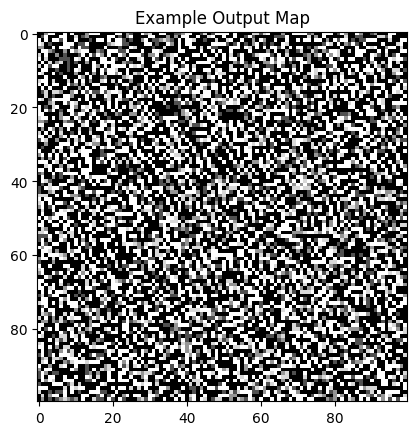

tensor([[[[4., 4., 2.,  ..., 4., 4., 4.],
          [4., 3., 0.,  ..., 4., 4., 4.],
          [0., 4., 0.,  ..., 4., 0., 0.],
          ...,
          [1., 4., 4.,  ..., 0., 4., 4.],
          [4., 1., 4.,  ..., 4., 4., 1.],
          [4., 2., 4.,  ..., 3., 0., 0.]]]], grad_fn=<ClampBackward1>)

In [35]:
# Visualize the first generated map
test_input = torch.randn(1, input_channels, 100, 100)  # Example input
output = generator(test_input)
print(f"Generated output Shape: {output.shape}")

plt.imshow(output.squeeze().detach().numpy(), cmap='Grays')
plt.title("Example Output Map")
plt.show()
output

Test the generator on real RRT Paths

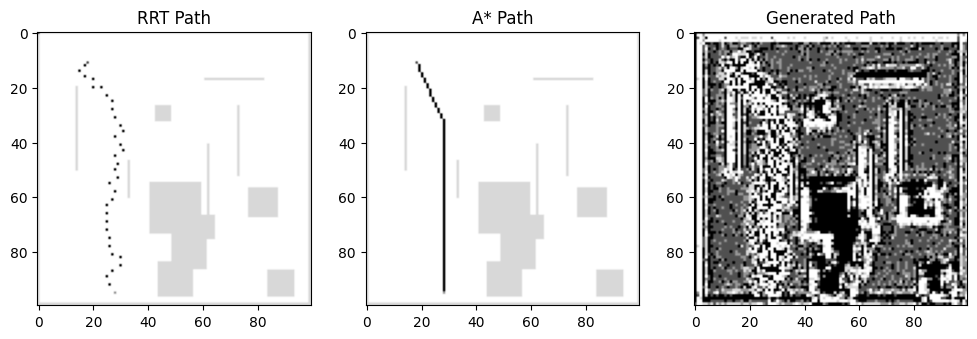

In [36]:
# Get a batch of data
data = next(iter(dataloader))
maps = data['map']

# Modify the maps with the RRT paths
modified_maps = []
for i in range(maps.size(0)):
    modified_map_rrt = modify_map_with_path(maps[i].numpy(), data['rrt_path'][i].numpy())
    modified_map_astar = modify_map_with_path(maps[i].numpy(), data['astar_path'][i].numpy())
    break

# Convert the map to a PyTorch tensor and add a batch and channel dimension
rrt_map_tensor = torch.tensor(modified_map_rrt).unsqueeze(0).unsqueeze(0).float()
astar_map_tensor = torch.tensor(modified_map_astar).unsqueeze(0).unsqueeze(0).float()

# Check if GPU is available and move the tensor to GPU for faster computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rrt_map_tensor = rrt_map_tensor.to(device)
generator = generator.to(device)

# Generate the output map
with torch.no_grad():  # No need to track gradients
    generated_map_tensor = generator(rrt_map_tensor)

# Visualize the original and generated maps
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
# Move the tensor back to CPU and convert it to NumPy for visualization
plt.imshow(rrt_map_tensor.squeeze().cpu().numpy(), cmap='Grays')
plt.title("RRT Path")
# plt.colorbar()

# plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 2)
# Move the tensor back to CPU and convert it to NumPy for visualization
plt.imshow(astar_map_tensor.squeeze().cpu().numpy(), cmap='Grays')
plt.title("A* Path")
# plt.colorbar()

# plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 3)
# Move the tensor back to CPU and convert it to NumPy for visualization
plt.imshow(generated_map_tensor.squeeze().cpu().numpy(), cmap='Grays')
plt.title("Generated Path")
# plt.colorbar()

plt.savefig('../captures/training_start0.png', dpi=500)
plt.show()

GAN Loss Function

In [22]:
# Adversarial loss (Binary Cross Entropy)
adversarial_loss = nn.BCELoss()

# Reconstruction loss (Mean Squared Error)
reconstruction_loss = nn.MSELoss()

def generator_loss(disc_generated_output, gen_output, target):
    """
    Calculate the generator's loss.

    Parameters:
    - disc_generated_output: output from the discriminator for generated images
    - gen_output: generated maps from the generator
    - target: real A* maps

    Returns:
    - total_gen_loss: the total loss for the generator
    """
    # Adversarial loss: how well the generator was able to trick the discriminator
    real_labels = torch.ones_like(disc_generated_output)
    gen_adv_loss = adversarial_loss(disc_generated_output, real_labels)

    # Reconstruction loss: how similar the generated map is to the real map
    gen_recon_loss = reconstruction_loss(gen_output, target)

    # Total generator loss
    alpha = 0.5  # weight for reconstruction loss
    total_gen_loss = gen_adv_loss + alpha * gen_recon_loss

    return total_gen_loss

## Discriminator

In [23]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Define the architecture of the PatchGAN discriminator
        self.model = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(2, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # Second convolutional layer
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Third convolutional layer
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # Fourth convolutional layer
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),  # Stride of 1 to maintain patch size
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # Final layer to a patch output
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)  # Produces a 30x30 patch grid
        )

    def forward(self, map1, map2):
        # Concatenate the two input maps along the channel dimension
        combined_input = torch.cat([map1, map2], dim=1)
        # Forward pass through the network to produce a patch grid
        patch_out = self.model(combined_input)
        return patch_out

Discriminator Loss

In [24]:
# Binary Cross-Entropy loss with logits
# This loss combines a Sigmoid layer and the BCELoss in one single class
criterion = nn.BCEWithLogitsLoss()

def discriminator_loss(disc_real_output, disc_generated_output):
    """
    Calculate discriminator loss.
    
    Args:
    - disc_real_output (tensor): Discriminator output for real data.
    - disc_generated_output (tensor): Discriminator output for generated (fake) data.
    
    Returns:
    - total_disc_loss (tensor): Total loss for the discriminator.
    """
    # Real loss - how well the discriminator classifies real images
    real_loss = criterion(disc_real_output, torch.ones_like(disc_real_output))
    
    # Generated loss - how well the discriminator classifies generated images
    generated_loss = criterion(disc_generated_output, torch.zeros_like(disc_generated_output))
    
    # Total discriminator loss
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss

# Training

Check for CUDA

In [25]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
print("Using device:", device)

Using device: cpu


In [27]:
# Parameters
num_epochs = 4000 # Number of epochs for training
input_channels = 1  # Assuming grayscale input maps
output_channels = 1  # Assuming grayscale output maps

# Initialize your models
generator = UNetGenerator(input_channels, output_channels).to(device)
discriminator = Discriminator().to(device)

# Define optimizers for both generator and discriminator
gen_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
disc_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Keep track of minimum loss for model saving
best_g_total_loss = float('inf')

# TensorBoard setup
log_dir = 'runs/GAN_experiment'
os.makedirs(log_dir, exist_ok=True)
# Setup TensorBoard writer
writer = SummaryWriter(log_dir)

# Checkpointing functions
def save_checkpoint(model, optimizer, filename):
    """
    Save a model checkpoint.

    Parameters:
    - model: PyTorch model to be saved
    - optimizer: Optimizer state to be saved
    - filename: Path where the checkpoint will be saved
    """
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, filename)

for epoch in range(num_epochs):
    for step, data in enumerate(dataloader):
        maps = data['map'].to(device)
        rrt_paths = data['rrt_path'].to(device)
        astar_paths = data['astar_path'].to(device)

        # Directly modify the map with the RRT and A* paths
        maps = maps.unsqueeze(1)
        rrt_modified_maps = modify_map_with_path_tensor(maps, rrt_paths)
        astar_modified_maps = modify_map_with_path_tensor(maps, astar_paths)

        # Generate maps using the generator
        fake_astar_maps = generator(rrt_modified_maps)

        # Train Discriminator
        disc_optimizer.zero_grad()
        # Get discriminator outputs for real and fake data
        disc_real_output = discriminator(rrt_modified_maps, astar_modified_maps)
        disc_fake_output = discriminator(rrt_modified_maps, fake_astar_maps.detach())
        # Calculate total discriminator loss
        disc_loss = discriminator_loss(disc_real_output, disc_fake_output)
        # Backward pass and optimizer step
        disc_loss.backward()
        disc_optimizer.step()

        # Train Generator
        gen_optimizer.zero_grad()
        disc_fake_output = discriminator(rrt_modified_maps, fake_astar_maps)
        print(f"disc_fake_output {disc_fake_output}")
        print(f"fake_astar_maps {fake_astar_maps}")
        print(f"astar_modified_maps {astar_modified_maps}")
        gen_loss = generator_loss(disc_fake_output, fake_astar_maps, astar_modified_maps)
        gen_loss.backward()
        gen_optimizer.step()

        if step % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step {step}, G Total Loss: {gen_loss.item()}, D Loss: {disc_loss.item()}")
            writer.add_scalar('Generator Total Loss', gen_loss.item(), global_step=step)
            writer.add_scalar('Discriminator Loss', disc_loss.item(), global_step=step)
            if gen_loss.item() < best_g_total_loss:
                best_g_total_loss = gen_loss.item()
                save_checkpoint(generator, gen_optimizer, 'best_generator_checkpoint.pth')
                save_checkpoint(discriminator, disc_optimizer, 'best_discriminator_checkpoint.pth')
                print("Models saved with new minimum generator loss.")


disc_fake_output tensor([[[[ 0.7064,  1.1415,  1.1662,  1.5504,  1.3936,  0.9797,  1.5682,
            1.6526,  1.5697,  0.8218],
          [ 1.4691,  1.1641,  1.2118,  1.5738,  1.3317,  1.0279,  1.6219,
            1.5624,  0.9761,  0.7062],
          [ 1.0904,  1.3622,  1.4012,  1.5952,  1.1404,  0.6971,  1.5449,
            1.5656,  1.0698,  0.9454],
          [ 1.5961,  1.4744,  1.4948,  1.2962,  0.5328,  1.3185,  1.8169,
            1.2329,  1.5427,  0.8308],
          [ 1.0523,  1.4002,  0.9621,  0.9709,  1.1697,  2.0146,  2.2402,
            1.8347,  0.9803,  1.0367],
          [ 0.6150,  0.8452,  0.7133,  1.0105,  1.0160,  1.7676,  2.5376,
            1.4468,  1.0504,  1.0294],
          [ 0.7543,  0.8816,  0.9384,  1.4117,  1.2456,  1.8162,  1.7762,
            1.1725,  1.0451,  1.1200],
          [ 0.9685,  1.1224,  0.8414,  1.5474,  1.8699,  1.6644,  1.1237,
            1.0682,  1.0687,  1.0715],
          [ 1.1819,  1.2253,  1.5554,  2.3295,  1.7273,  1.6530,  1.0562,
     

RuntimeError: all elements of input should be between 0 and 1

In [17]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.transformer = nn.Transformer(d_model=input_size, nhead=4, num_encoder_layers=3, num_decoder_layers=3)
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, src, mask=None):
        # src: [batch_size, seq_len, input_size]
        transformer_output = self.transformer(src, src, src_key_padding_mask=mask)
        output = self.fc(transformer_output)
        return output

In [19]:
generator = Generator(input_size=100, hidden_size=128, output_size=50)
# Example input (dummy data)
src = torch.rand(4, 50, 100)  # [batch_size, seq_len, input_size]
mask = torch.rand(4, 50).bool()  # Random mask for example

# Forward pass
generated_path = generator(src, mask)
generated_path

c:\Users\jjaso\anaconda3\envs\plan2planenv\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


AssertionError: expecting key_padding_mask shape of (50, 4), but got torch.Size([4, 50])